In [1]:
! pip install --upgrade ultralytics -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 9.0 MB/s eta 0:00:00


In [2]:
import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO

In [3]:
import sys
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5153'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5153
/content/gdrive/My Drive/BT5153


In [68]:
# Create CFG class
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 1 if DEBUG else 10  #
    BATCH_SIZE = 4  # 4 , 8

    BASE_MODEL = 'yolov8n'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'YOLOv8n_Final_Auto{EPOCHS}_epochs'

    OPTIMIZER = 'auto'  # Can be 'SGD', 'Adam', or 'auto'
    LR = 1e-2
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/gdrive/My Drive/BT5153/Project/MRI/'
    OUTPUT_DIR = './'

CFG.BASE_MODEL_WEIGHTS


'yolov8n.pt'

In [69]:
# Create YAML file
yaml_dict = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

# Function to write and read YAML file, then print it
def manage_yaml_file():
    # Writing to YAML
    file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
    with open(file_path, 'w') as file:
        yaml.dump(yaml_dict, file)

    # Reading from YAML
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return

    # Printing YAML
    formatted_yaml = yaml.dump(data, default_flow_style=False)
    print(formatted_yaml)

manage_yaml_file()

names:
- Glioma
- Meningioma
- No Tumor
- Pituitary
nc: 4
test: /content/gdrive/My Drive/BT5153/Project/MRI/test
train: /content/gdrive/My Drive/BT5153/Project/MRI/train
val: /content/gdrive/My Drive/BT5153/Project/MRI/valid



Type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape: (640, 640, 3)


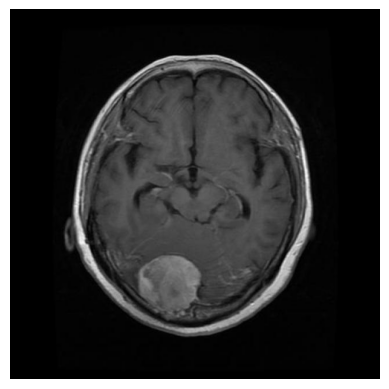

In [70]:
EXAMPLE_IMAGE = 'train/images/Tr-me_0078_jpg.rf.bb2bc1538503844c72ac7e0ab42b5ac0.jpg'

def display_image(image_path, print_info=True, hide_axis=False):
    # Construct full path to the image
    full_path = os.path.join(CFG.CUSTOM_DATASET_DIR, image_path)
    try:
        img = Image.open(full_path)
        plt.imshow(img)
    except IOError as e:
        print(f"Error opening image: {e}")
        return

    # Print image info
    if print_info:
        img_np = np.array(img)
        print(f'Type: {type(img)}')
        print(f'Shape: {img_np.shape}')
    if hide_axis:
        plt.axis('off')

    plt.show()

display_image(EXAMPLE_IMAGE, print_info=True, hide_axis=True)

In [71]:
# check whether each image has a corresponding label
image_dir = '/content/gdrive/My Drive/BT5153/Project/MRI/train/images'
label_dir = '/content/gdrive/My Drive/BT5153/Project/MRI/train/labels'

# Get list of image files
image_files = os.listdir(image_dir)
image_files = [os.path.splitext(file)[0] for file in image_files if file.endswith('.jpg')]  # Strip the extension

# Get list of label files
label_files = os.listdir(label_dir)
label_files = [os.path.splitext(file)[0] for file in label_files if file.endswith('.txt')]  # Strip the extension

# Check if each image has a corresponding label
missing_labels = [img for img in image_files if img not in label_files]

if missing_labels:
    print("Removing images without corresponding labels:")
    for img in missing_labels:
        img_file = img + '.jpg'
        img_path = os.path.join(image_dir, img_file)
        os.remove(img_path)  # Remove the file
        print(f"Removed {img_file}")
else:
    print("All images have corresponding labels.")

All images have corresponding labels.


In [72]:

def get_image_properties(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image file")
    return {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) > 2 else 1,
        "dtype": img.dtype
    }

# Example usage
example = '/content/gdrive/My Drive/BT5153/Project/MRI/train/images/Tr-me_0078_jpg.rf.bb2bc1538503844c72ac7e0ab42b5ac0.jpg'
img_properties = get_image_properties(example)
print(img_properties)


{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}


In [73]:
# Get dataset statistic

def get_dataset_stats():
    class_idx = {str(i): cls for i, cls in enumerate(CFG.CLASSES)}
    class_stat = {}
    data_len = {}
    class_info = []

    for mode in ['train', 'valid', 'test']:
        class_count = {cls: 0 for cls in CFG.CLASSES}
        path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

        try:
            files = os.listdir(path)
        except FileNotFoundError:
            print(f"Directory not found: {path}")
            continue

        for file in files:
            with open(os.path.join(path, file)) as f:
                lines = [line.split()[0] for line in f.readlines()]
                for cls in set(lines):
                    class_count[class_idx[cls]] += 1

        data_len[mode] = sum(class_count.values())
        class_stat[mode] = class_count
        class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

    return pd.DataFrame(class_info)

# display the dataset stats
dataset_stats_df = get_dataset_stats()
dataset_stats_df

,Mode,Glioma,Meningioma,No Tumor,Pituitary,Data_Volume
0,train,1128,716,670,876,3390
1,valid,322,248,198,236,1004
2,test,80,63,49,54,246


In [78]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
model.to('cuda')

results = model.predict(
    source = example,

    classes = [0],
    conf = 0.30,
    device = 'cuda', # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

### check predictions with base model
inference_output = example.split('/')[-1]
display_image(f'runs/detect/predict/{inference_output}')


image 1/1 /content/gdrive/My Drive/BT5153/Project/MRI/train/images/Tr-me_0078_jpg.rf.bb2bc1538503844c72ac7e0ab42b5ac0.jpg: 640x640 (no detections), 9.4ms
Speed: 1.8ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels
Error opening image: [Errno 2] No such file or directory: '/content/gdrive/My Drive/BT5153/Project/MRI/runs/detect/predict/Tr-me_0078_jpg.rf.bb2bc1538503844c72ac7e0ab42b5ac0.jpg'


In [79]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content/gdrive/My Drive/BT5153


In [80]:

# Path to the Ultralytics settings file
settings_file_path = '/root/.config/Ultralytics/settings.yaml'

# New dataset download directory
new_dataset_dir = '/content/gdrive/MyDrive/BT5153/Project/MRI'

# Function to update the dataset directory in settings.yaml
def update_ultralytics_settings(settings_path, new_dir):
    try:
        # Read the settings file
        with open(settings_path, 'r') as file:
            settings = yaml.safe_load(file)

        if 'download' in settings and 'path' in settings['download']:
            settings['download']['path'] = new_dir

        with open(settings_path, 'w') as file:
            yaml.safe_dump(settings, file)

        print("Settings updated successfully.")

    except FileNotFoundError:
        print("Settings file not found.")
    except yaml.YAMLError as e:
        print(f"Error processing YAML file: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

update_ultralytics_settings(settings_file_path, new_dataset_dir)


Settings updated successfully.


In [81]:
# train model

def train_model(config, img_properties):
    # the path to the data.yaml file
    data_yaml_path = '/content/gdrive/MyDrive/BT5153/Project/MRI/data.yaml'

    # Train
    model.train(
        data=data_yaml_path,
        task='detect',
        imgsz=(img_properties['height'], img_properties['width']),
        epochs=config.EPOCHS,
        batch=config.BATCH_SIZE,
        optimizer=config.OPTIMIZER,
        lr0=config.LR,
        lrf=config.LR_FACTOR,
        weight_decay=config.WEIGHT_DECAY,
        dropout=config.DROPOUT,
        fraction=config.FRACTION,
        patience=config.PATIENCE,
        profile=config.PROFILE,
        label_smoothing=config.LABEL_SMOOTHING,
        name=f'{config.BASE_MODEL}_{config.EXP_NAME}',
        seed=config.SEED,
        val=True,
        amp=True,
        exist_ok=True,
        resume=False,
        device='cuda',
        verbose=False
    )


train_model(CFG, img_properties)


Ultralytics YOLOv8.2.5 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/gdrive/MyDrive/BT5153/Project/MRI/data.yaml, epochs=10, time=None, patience=20, batch=4, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8n_YOLOv8n_Final_Auto10_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /content/gdrive/MyDrive/BT5153/Project/MRI/train/labels.cache... 3390 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3390/3390 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/gdrive/MyDrive/BT5153/Project/MRI/valid/labels.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.935G      2.041      3.978      2.095          2        640: 100%|██████████| 848/848 [01:10<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 16.43it/s]


                   all       1004       1010      0.672      0.638      0.681      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.914G      1.715      2.197      1.731          2        640: 100%|██████████| 848/848 [01:06<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.28it/s]

                   all       1004       1010      0.759      0.678       0.74      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.906G       1.65       1.64      1.663          2        640: 100%|██████████| 848/848 [01:06<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.59it/s]

                   all       1004       1010      0.709      0.716      0.791      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.904G      1.617      1.381      1.617          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.83it/s]

                   all       1004       1010      0.808      0.793      0.853      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.904G      1.575      1.214       1.58          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.43it/s]

                   all       1004       1010      0.812      0.786      0.847      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.904G      1.529      1.098      1.538          2        640: 100%|██████████| 848/848 [01:06<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.28it/s]

                   all       1004       1010       0.84      0.811      0.886       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.902G      1.495      1.004      1.507          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.58it/s]

                   all       1004       1010      0.878      0.838      0.904      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.904G       1.45     0.9375      1.475          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.17it/s]

                   all       1004       1010      0.882      0.859      0.916      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.904G      1.429     0.8774      1.458          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:07<00:00, 17.63it/s]

                   all       1004       1010      0.889       0.88       0.93      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.902G      1.387     0.8248      1.423          2        640: 100%|██████████| 848/848 [01:05<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:06<00:00, 18.13it/s]

                   all       1004       1010      0.898      0.884      0.934      0.543



10 epochs completed in 0.207 hours.
Optimizer stripped from runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.pt...
Ultralytics YOLOv8.2.5 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 126/126 [00:06<00:00, 19.79it/s]


                   all       1004       1010      0.896      0.886      0.934      0.544
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs


In [82]:
# Export the model
model.export(
    format = 'onnx',
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.5 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 0.9s, saved as 'runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.onnx' (11.7 MB)

Export complete (1.1s)
Results saved to /content/gdrive/MyDrive/BT5153/runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.onnx imgsz=640 data=/content/gdrive/MyDrive/BT5153/Project/MRI/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/weights/best.onnx'

In [83]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,2.0412,3.97770,2.0949,0.67225,0.63786,0.68104,0.34540,1.7357,2.21060,1.7590,0.000416,0.000416,0.000416
1,2,1.7146,2.19660,1.7309,0.75885,0.67770,0.74002,0.39283,1.6809,1.64030,1.6994,0.000750,0.000750,0.000750
2,3,1.6502,1.64010,1.6633,0.70934,0.71630,0.79072,0.41488,1.6450,1.44650,1.6608,0.001002,0.001002,0.001002
3,4,1.6171,1.38140,1.6167,0.80756,0.79263,0.85285,0.46798,1.6299,1.20380,1.6294,0.000879,0.000879,0.000879
4,5,1.5748,1.21380,1.5801,0.81159,0.78616,0.84715,0.46236,1.5833,1.23720,1.5933,0.000755,0.000755,0.000755
5,6,1.5288,1.09850,1.5375,0.84019,0.81121,0.88618,0.49012,1.5724,1.05620,1.5718,0.000631,0.000631,0.000631
6,7,1.4946,1.00400,1.5074,0.87779,0.83756,0.90436,0.50820,1.5761,1.01870,1.5576,0.000508,0.000508,0.000508
7,8,1.4500,0.93754,1.4747,0.88182,0.85937,0.91587,0.51809,1.5444,0.97286,1.5512,0.000384,0.000384,0.000384
8,9,1.4286,0.87736,1.4581,0.88930,0.87951,0.92968,0.53538,1.5310,0.88904,1.5213,0.000260,0.000260,0.000260
9,10,1.3866,0.82477,1.4233,0.89760,0.88403,0.93354,0.54283,1.5403,0.87513,1.5307,0.000136,0.000136,0.000136


In [84]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

./runs/detect/yolov8n_YOLOv8n_Final_Auto10_epochs/val_batch0_pred.jpg


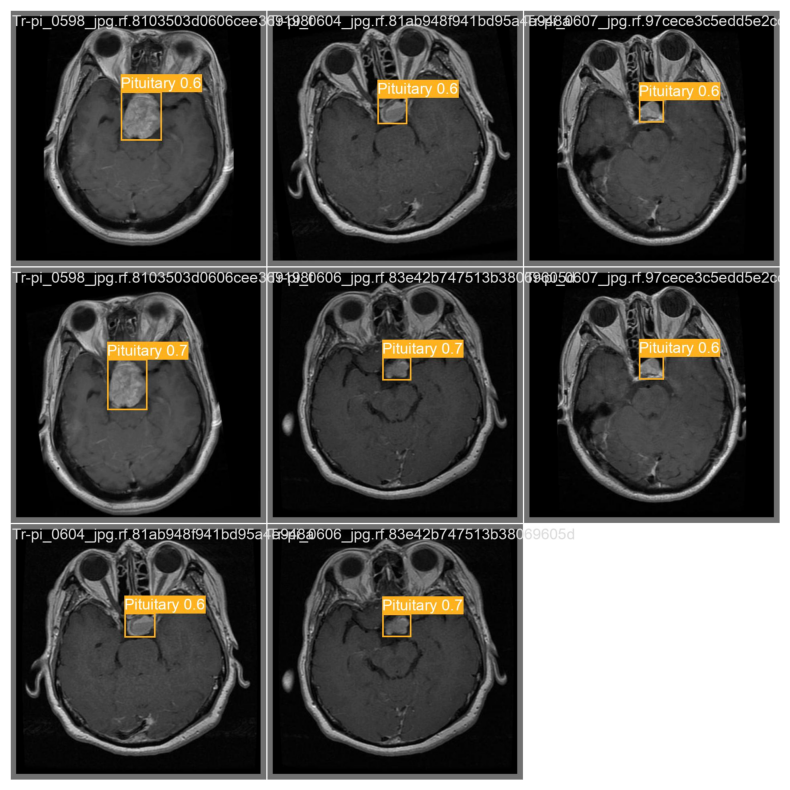

In [86]:
def display_image(image_path, print_info=False, hide_axis=True):
    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    if print_info:
        print(f"Info for image: {image_path}")
    if hide_axis:
        plt.axis('off')

    plt.show()

# Check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info=False, hide_axis=True)